In [1]:
import pandas as pd
import numpy as np
import math, time
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn import metrics 
from scipy import stats

from keras.models import Sequential
from keras.layers import Dense, Activation, BatchNormalization

Using TensorFlow backend.


In [2]:
#!pip install tensorflow
#!pip install sklearn
#!pip install keras
#!pip install d2l
#!pip install mxnet

In [3]:
# If pandas is not installed, please uncomment the following line:
#!pip install pandas
#!pip install sklearn
%matplotlib inline
import d2l
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import data as gdata, loss as gloss, nn, utils

In [4]:
# POST-LASSO STARTS HERE

In [5]:
filtered = pd.read_csv('filtered.csv') 

In [6]:
filtered['HADM_ID'] = filtered.index.values

In [7]:
#bert = pd.read_pickle('bert.pkl')
bert = pd.read_pickle('bert_5491.pkl')

In [8]:
bert_df = pd.merge(filtered, bert, on='HADM_ID',
              how='left') 

In [9]:
bert_df['VEC'] = bert_df['VEC'].apply(lambda d: d if isinstance(d, np.ndarray) else [[0]]*768)
bert_df = pd.merge(bert_df.iloc[:,:-1], 
                   pd.DataFrame(bert_df.VEC.values.tolist(), index= bert_df.HADM_ID).applymap(lambda x: x[0]),
                   on='HADM_ID',
                   how='inner')


In [10]:
from keras.preprocessing import sequence

In [11]:
from sklearn import preprocessing

### keras mlp : without bert

In [12]:
#filtered = pd.read_csv('filtered.csv')
X = filtered.drop(columns = ['Unnamed: 0', 'LOS'])
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)
y = filtered['LOS']

In [13]:
X_train_demo, X_test_demo, y_train_demo, y_test_demo = train_test_split(X, y, test_size=0.2, random_state=0)

X_train = X_train_demo
y_train = y_train_demo
X_test = X_test_demo
y_test = y_test_demo

In [14]:
from keras import regularizers, optimizers
model = Sequential()
model.add(Dense(256, kernel_initializer = 'normal', activation = 'relu', kernel_regularizer = regularizers.l2(0.01)))
#model.add(Dense(64, kernel_initializer = 'normal', activation = 'relu', kernel_regularizer = regularizers.l2(0.01)))
model.add(BatchNormalization(axis=-1, 
                             momentum=0.99, epsilon=0.001, 
                             center=True, scale=True, 
                             beta_initializer='zeros', 
                             gamma_initializer='ones', 
                             moving_mean_initializer='zeros', 
                             moving_variance_initializer='ones', 
                             beta_regularizer=None, gamma_regularizer=None, 
                             beta_constraint=None, gamma_constraint=None))
model.add(Dense(128, activation = 'relu', kernel_regularizer = regularizers.l2(0.01)))
model.add(BatchNormalization(axis=-1, 
                             momentum=0.99, epsilon=0.001, 
                             center=True, scale=True, 
                             beta_initializer='zeros', 
                             gamma_initializer='ones', 
                             moving_mean_initializer='zeros', 
                             moving_variance_initializer='ones', 
                             beta_regularizer=None, gamma_regularizer=None, 
                             beta_constraint=None, gamma_constraint=None))
model.add(Dense(1))
#model.compile(loss = 'rmse', optimizer = 'adam')
adm = optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

print(f'training data dims: X: {X_train.shape}, y: {y_train.shape}')
print(f'test data dims: X: {X_test.shape}, y: {y_test.shape}')

history = model.fit(X_train, y_train, epochs = 200, batch_size=256)


Instructions for updating:
Colocations handled automatically by placer.
training data dims: X: (47102, 121), y: (47102,)
test data dims: X: (11776, 121), y: (11776,)


/home/ubuntu/miniconda3/envs/gluon/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Instructions for updating:
Use tf.cast instead.
Epoch 1/200
47102/47102 [==============================] - 2s 52us/step - loss: 136906.3112
Epoch 2/200
47102/47102 [==============================] - 1s 23us/step - loss: 114986.6317
Epoch 3/200
47102/47102 [==============================] - 1s 23us/step - loss: 89067.1823
Epoch 4/200
47102/47102 [==============================] - 1s 23us/step - loss: 67024.9990
Epoch 5/200
47102/47102 [==============================] - 1s 24us/step - loss: 51845.8183
Epoch 6/200
47102/47102 [==============================] - 1s 24us/step - loss: 42613.9067
Epoch 7/200
47102/47102 [==============================] - 1s 23us/step - loss: 35985.2902
Epoch 8/200
47102/47102 [==============================] - 1s 24us/step - loss: 32246.4301
Epoch 9/200
47102/47102 [==============================] - 1s 24us/step - loss: 30338.6765
Epoch 10/200
47102/47102 [==============================] - 1s 23us/step - loss: 28142.7779
Epoch 11/200
47102/47102 [=============

In [31]:
a = np.sqrt(8016.4939)
b = 19.762
a/b

4.5306586037849

In [15]:
predictions = model.predict(X_test)
predictions = predictions.reshape(len(y_test),)
difference = predictions - y_test 
threshold_15 = 0.15*y_test
acc_test_15 = sum(threshold_15 - abs(difference) > 0) / len(y_test)
print('test accuracy: ', acc_test_15)


test accuracy:  0.16355298913043478


In [16]:
predictions_train = model.predict(X_train)
predictions_train = predictions_train.reshape(len(y_train), )
threshold_train = 0.15*y_train
difference_train = predictions_train - y_train
acc_train = sum(threshold_train - abs(difference_train) > 0) / len(y_train)
print('train accuracy: ',acc_train)

train accuracy:  0.3668634028279054


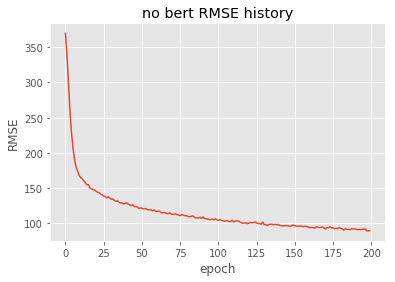

In [19]:
plt.plot(np.sqrt(history.history['loss']))
plt.title('no bert RMSE history')
plt.xlabel('epoch')
plt.ylabel('RMSE')
plt.savefig('no_bert_rmse.png')
plt.show()

# with bert

In [12]:
#filtered = pd.read_csv('filtered.csv')
X = bert_df.drop(columns = ['Unnamed: 0'])
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)
y = filtered.iloc[:,121]

In [13]:
X_train_demo, X_test_demo, y_train_demo, y_test_demo = train_test_split(X, y, test_size=0.2, random_state=0)

X_train = X_train_demo
y_train = y_train_demo
X_test = X_test_demo
y_test = y_test_demo

In [14]:
from keras import regularizers, optimizers
model = Sequential()
model.add(Dense(256, kernel_initializer = 'normal', activation = 'relu', kernel_regularizer = regularizers.l2(0.01)))
#model.add(Dense(64, kernel_initializer = 'normal', activation = 'relu', kernel_regularizer = regularizers.l2(0.01)))
model.add(BatchNormalization(axis=-1, 
                             momentum=0.99, epsilon=0.001, 
                             center=True, scale=True, 
                             beta_initializer='zeros', 
                             gamma_initializer='ones', 
                             moving_mean_initializer='zeros', 
                             moving_variance_initializer='ones', 
                             beta_regularizer=None, gamma_regularizer=None, 
                             beta_constraint=None, gamma_constraint=None))
model.add(Dense(128, activation = 'relu', kernel_regularizer = regularizers.l2(0.01)))
model.add(BatchNormalization(axis=-1, 
                             momentum=0.99, epsilon=0.001, 
                             center=True, scale=True, 
                             beta_initializer='zeros', 
                             gamma_initializer='ones', 
                             moving_mean_initializer='zeros', 
                             moving_variance_initializer='ones', 
                             beta_regularizer=None, gamma_regularizer=None, 
                             beta_constraint=None, gamma_constraint=None))
model.add(Dense(1))
#model.compile(loss = 'rmse', optimizer = 'adam')
adm = optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

print(f'training data dims: X: {X_train.shape}, y: {y_train.shape}')
print(f'test data dims: X: {X_test.shape}, y: {y_test.shape}')

history = model.fit(X_train, y_train, epochs = 200, batch_size=256)


Instructions for updating:
Colocations handled automatically by placer.
training data dims: X: (47102, 890), y: (47102,)
test data dims: X: (11776, 890), y: (11776,)


/home/ubuntu/miniconda3/envs/gluon/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Instructions for updating:
Use tf.cast instead.
Epoch 1/200
47102/47102 [==============================] - 6s 133us/step - loss: 134382.3217
Epoch 2/200
47102/47102 [==============================] - 1s 28us/step - loss: 101200.4479
Epoch 3/200
47102/47102 [==============================] - 1s 27us/step - loss: 65139.3885
Epoch 4/200
47102/47102 [==============================] - 1s 27us/step - loss: 35908.5646
Epoch 5/200
47102/47102 [==============================] - 1s 27us/step - loss: 17579.1704
Epoch 6/200
47102/47102 [==============================] - 1s 28us/step - loss: 9433.7458
Epoch 7/200
47102/47102 [==============================] - 1s 27us/step - loss: 5432.3373
Epoch 8/200
47102/47102 [==============================] - 1s 27us/step - loss: 4155.0276
Epoch 9/200
47102/47102 [==============================] - 1s 26us/step - loss: 2937.2617
Epoch 10/200
47102/47102 [==============================] - 1s 27us/step - loss: 2466.9982
Epoch 11/200
47102/47102 [=================

In [17]:
predictions = model.predict(X_test)
predictions = predictions.reshape(len(y_test),)
difference = predictions - y_test 
threshold_15 = 0.15*y_test
acc_test_15 = sum(threshold_15 - abs(difference) > 0) / len(y_test)
print('test accuracy: ', acc_test_15)


test accuracy:  0.8481657608695652


In [15]:
predictions_train = model.predict(X_train)
predictions_train = predictions_train.reshape(len(y_train), )
threshold_train = 0.15*y_train
difference_train = predictions_train - y_train
acc_train = sum(threshold_train - abs(difference_train) > 0) / len(y_train)
print('train accuracy: ',acc_train)

train accuracy:  0.854464778565666


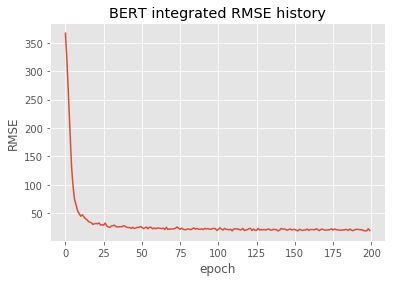

In [16]:
plt.plot(np.sqrt(history.history['loss']))
plt.title('BERT integrated RMSE history')
plt.xlabel('epoch')
plt.ylabel('RMSE')
plt.savefig('bert_rmse.png')
plt.show()